# Tutorial 3: Getting Started with ``optax`` Optimizers

**Difficulty**: Beginner  
**Duration**: 20-30 minutes  
**Prerequisites**: Basic knowledge of JAX and neural networks

## Learning Objectives
- Understand the optimizer interface in braintools
- Use basic optimizers (SGD, Adam, AdamW)
- Train a simple neural network
- Compare different optimizer behaviors

## Topics Covered
1. **Setting up a simple model**
   - Creating a basic feedforward network with brainstate
   - Defining a loss function

2. **Using basic optimizers**
   - SGD with momentum
   - Adam optimizer
   - AdamW with weight decay

3. **Training loop implementation**
   - Gradient computation
   - Parameter updates
   - Loss tracking

4. **Comparing optimizer performance**
   - Convergence speed comparison
   - Loss landscape visualization
   - Hyperparameter sensitivity

In [1]:
import time

import brainstate
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import braintools

## 1. Setting up a Simple Model

Let's start by creating a basic feedforward network using brainstate. This will be our test model for comparing different optimizers.

In [2]:
class FeedForwardNet(brainstate.nn.Module):
    """Simple feedforward network for classification."""

    def __init__(self, input_dim=784, hidden_dims=(128, 64), output_dim=10):
        super().__init__()

        # Build layers
        self.layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            self.layers.append(brainstate.nn.Linear(prev_dim, hidden_dim))
            prev_dim = hidden_dim

        # Output layer
        self.output_layer = brainstate.nn.Linear(prev_dim, output_dim)

    def __call__(self, x):
        # Forward pass through hidden layers
        for layer in self.layers:
            x = layer(x)
            x = jax.nn.relu(x)

        # Output layer (no activation for logits)
        x = self.output_layer(x)
        return x

## 2. Preparing MNIST Data

Let's create a simple MNIST-like dataset for our experiments.

In [3]:
def create_synthetic_mnist_data(n_samples=1000, seed=42):
    """Create synthetic MNIST-like data for demonstration."""

    with brainstate.random.seed_context(seed):
        # Create random input data (28x28 images flattened)
        X = brainstate.random.normal(size=(n_samples, 784)) * 0.5

        # Create random labels (10 classes)
        y = brainstate.random.randint(0, 10, size=(n_samples,))
        return X, y


# Generate training and validation data
X_train, y_train = create_synthetic_mnist_data(n_samples=5000, seed=42)
X_val, y_val = create_synthetic_mnist_data(n_samples=1000, seed=43)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")

Training data shape: (5000, 784)
Training labels shape: (5000,)
Validation data shape: (1000, 784)
Validation labels shape: (1000,)


## 3. Defining Loss Function and Gradient Computation

Following the style from grad_computation.py, we'll define our loss function and gradient computation.

In [4]:
def compute_loss_and_grads(model, X, y, param_states):
    """Compute loss and gradients following braintools style.
    
    Args:
        model: The neural network model
        X: Input data
        y: Target labels
        param_states: Dictionary of parameter states
    
    Returns:
        loss: Scalar loss value
        grads: Gradients with respect to parameters
        accuracy: Classification accuracy
    """

    def loss_fn():
        # Forward pass
        logits = model(X)

        # Compute cross-entropy loss
        log_probs = jax.nn.log_softmax(logits, axis=-1)
        one_hot = jax.nn.one_hot(y, num_classes=10)
        loss = -jnp.mean(jnp.sum(one_hot * log_probs, axis=-1))

        return loss

    # Compute loss
    loss = loss_fn()

    # Compute gradients with respect to parameters
    grads = brainstate.transform.grad(loss_fn, grad_states=param_states)()

    # Compute accuracy for monitoring
    logits = model(X)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == y)

    return loss, grads, accuracy

## 4. Training with Basic Optimizers

Now let's implement training loops for different optimizers: SGD, Adam, and AdamW.

In [5]:
def train_model(
    model: brainstate.nn.Module,
    optimizer: braintools.optim.OptaxOptimizer,
    n_epochs=50,
    batch_size=128,
    verbose=True
):
    # Get parameter states for gradient computation
    param_states = braintools.optim.UniqueStateManager(
        model.states(brainstate.ParamState)
    ).to_pytree()

    # Initialize optimizer state
    optimizer.register_trainable_weights(param_states)

    @brainstate.transform.jit
    def train_step(X_batch, y_batch):
        loss, grads, acc = compute_loss_and_grads(model, X_batch, y_batch, param_states)
        optimizer.update(grads)
        return loss, acc

    @brainstate.transform.jit
    def eval_step(X_batch, y_batch):
        loss, _, acc = compute_loss_and_grads(model, X_batch, y_batch, param_states)
        return loss, acc

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'epoch_time': []
    }

    n_batches = len(X_train) // batch_size

    for epoch in range(n_epochs):
        epoch_start = time.time()

        # Shuffle training data
        perm = brainstate.random.permutation(len(X_train))
        X_train_shuffled = X_train[perm]
        y_train_shuffled = y_train[perm]

        # Training metrics
        train_losses = []
        train_accs = []

        for batch_idx in range(n_batches):
            # Get batch
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]

            # Compute loss and gradients
            loss, acc = train_step(X_batch, y_batch)

            train_losses.append(float(loss))
            train_accs.append(float(acc))

        # Validation
        val_loss, val_acc = eval_step(X_val, y_val)
        optimizer.lr.step()  # Update learning rate if using a scheduler

        # Record metrics
        epoch_time = time.time() - epoch_start
        history['train_loss'].append(np.mean(train_losses))
        history['train_acc'].append(np.mean(train_accs))
        history['val_loss'].append(float(val_loss))
        history['val_acc'].append(float(val_acc))
        history['epoch_time'].append(epoch_time)

        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{n_epochs} - "
                  f"Train Loss: {history['train_loss'][-1]:.4f}, "
                  f"Train Acc: {history['train_acc'][-1]:.4f}, "
                  f"Val Loss: {history['val_loss'][-1]:.4f}, "
                  f"Val Acc: {history['val_acc'][-1]:.4f}, "
                  f"Time: {epoch_time:.2f}s")

    return history

### 4.1 Training with SGD

In [6]:
# Initialize model for SGD
model_sgd = FeedForwardNet()

# Create SGD optimizer with momentum
sgd_optimizer = braintools.optim.SGD(
    lr=braintools.optim.ExponentialLR(0.1, gamma=0.95),
    momentum=0.9
)

# Train with SGD
print("Training with SGD (with momentum)...")
history_sgd = train_model(model_sgd, sgd_optimizer, n_epochs=50, batch_size=128)

Training with SGD (with momentum)...
Epoch 10/50 - Train Loss: 0.0047, Train Acc: 1.0000, Val Loss: 6.0427, Val Acc: 0.0950, Time: 0.10s
Epoch 20/50 - Train Loss: 0.0020, Train Acc: 1.0000, Val Loss: 6.4993, Val Acc: 0.0920, Time: 0.10s
Epoch 30/50 - Train Loss: 0.0015, Train Acc: 1.0000, Val Loss: 6.6681, Val Acc: 0.0950, Time: 0.10s
Epoch 40/50 - Train Loss: 0.0013, Train Acc: 1.0000, Val Loss: 6.7519, Val Acc: 0.0950, Time: 0.09s
Epoch 50/50 - Train Loss: 0.0012, Train Acc: 1.0000, Val Loss: 6.7976, Val Acc: 0.0950, Time: 0.09s


### 4.2 Training with Adam

In [7]:
# Initialize model for Adam
model_adam = FeedForwardNet()

# Create Adam optimizer
adam_optimizer = braintools.optim.Adam(
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-8
)

# Train with Adam
print("Training with Adam...")
history_adam = train_model(model_adam, adam_optimizer, n_epochs=50, batch_size=128)

Training with Adam...
Epoch 10/50 - Train Loss: 0.1872, Train Acc: 0.9964, Val Loss: 4.0425, Val Acc: 0.0960, Time: 0.10s
Epoch 20/50 - Train Loss: 0.0134, Train Acc: 1.0000, Val Loss: 5.5207, Val Acc: 0.1000, Time: 0.08s
Epoch 30/50 - Train Loss: 0.0045, Train Acc: 1.0000, Val Loss: 6.1902, Val Acc: 0.1000, Time: 0.09s
Epoch 40/50 - Train Loss: 0.0022, Train Acc: 1.0000, Val Loss: 6.6483, Val Acc: 0.0990, Time: 0.10s
Epoch 50/50 - Train Loss: 0.0013, Train Acc: 1.0000, Val Loss: 7.0110, Val Acc: 0.0990, Time: 0.09s


### 4.3 Training with AdamW

In [8]:
# Initialize model for AdamW
model_adamw = FeedForwardNet()

# Create AdamW optimizer with weight decay
adamw_optimizer = braintools.optim.AdamW(
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.01
)

# Train with AdamW
print("Training with AdamW (with weight decay)...")
history_adamw = train_model(model_adamw, adamw_optimizer, n_epochs=50, batch_size=128)

Training with AdamW (with weight decay)...
Epoch 10/50 - Train Loss: 0.1904, Train Acc: 0.9974, Val Loss: 3.8565, Val Acc: 0.0980, Time: 0.11s
Epoch 20/50 - Train Loss: 0.0138, Train Acc: 1.0000, Val Loss: 5.2613, Val Acc: 0.0940, Time: 0.10s
Epoch 30/50 - Train Loss: 0.0048, Train Acc: 1.0000, Val Loss: 5.8808, Val Acc: 0.0930, Time: 0.09s
Epoch 40/50 - Train Loss: 0.0024, Train Acc: 1.0000, Val Loss: 6.3004, Val Acc: 0.0940, Time: 0.11s
Epoch 50/50 - Train Loss: 0.0014, Train Acc: 1.0000, Val Loss: 6.6224, Val Acc: 0.0930, Time: 0.10s


## 5. Comparing Optimizer Performance

Let's visualize and compare the performance of different optimizers.

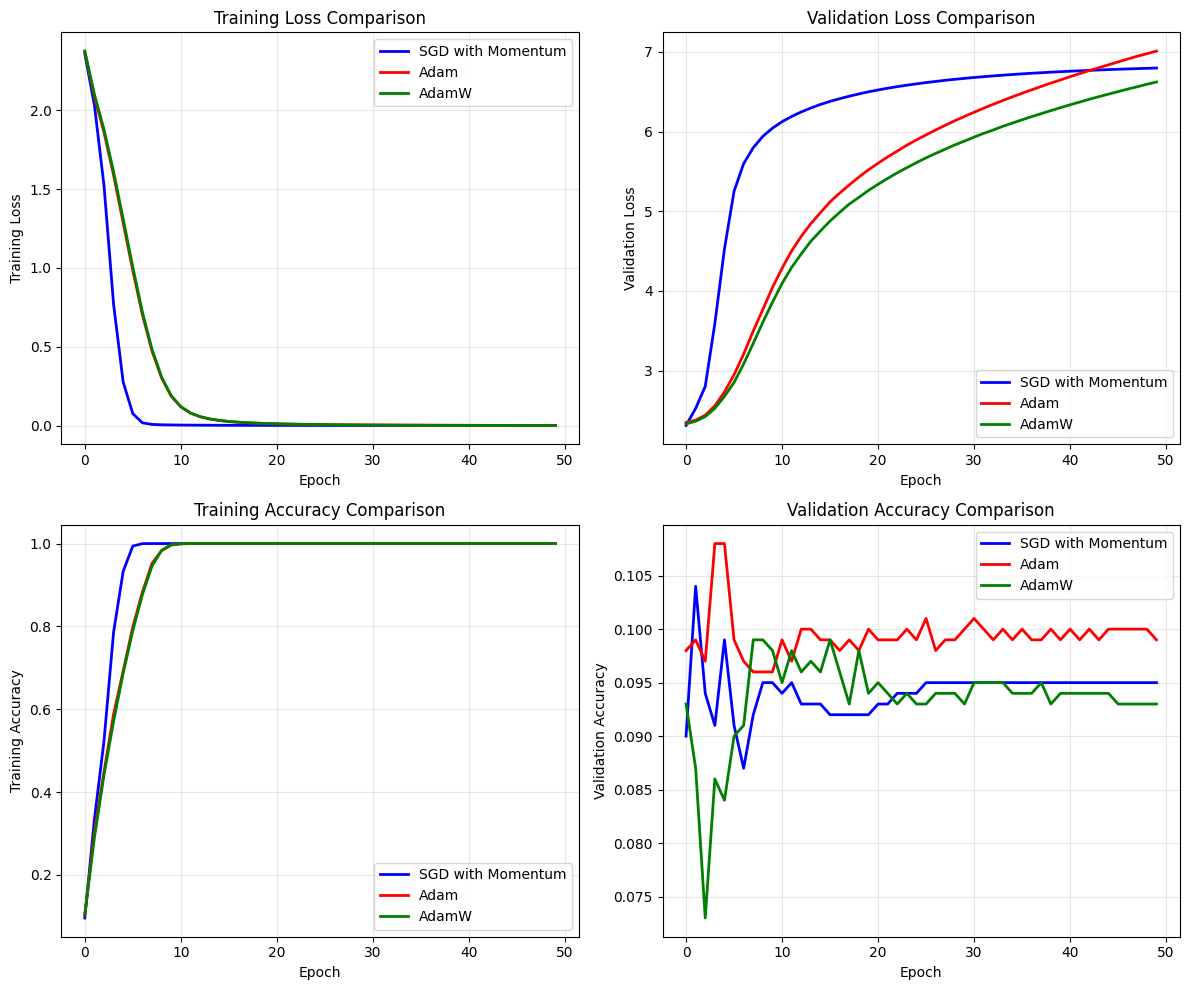

In [9]:
def plot_optimizer_comparison(histories, names):
    """Plot comparison of different optimizers."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    colors = ['blue', 'red', 'green', 'orange', 'purple']

    # Training loss
    ax = axes[0, 0]
    for i, (history, name) in enumerate(zip(histories, names)):
        ax.plot(history['train_loss'], label=name, color=colors[i], linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Loss')
    ax.set_title('Training Loss Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Validation loss
    ax = axes[0, 1]
    for i, (history, name) in enumerate(zip(histories, names)):
        ax.plot(history['val_loss'], label=name, color=colors[i], linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Loss')
    ax.set_title('Validation Loss Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Training accuracy
    ax = axes[1, 0]
    for i, (history, name) in enumerate(zip(histories, names)):
        ax.plot(history['train_acc'], label=name, color=colors[i], linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Accuracy')
    ax.set_title('Training Accuracy Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Validation accuracy
    ax = axes[1, 1]
    for i, (history, name) in enumerate(zip(histories, names)):
        ax.plot(history['val_acc'], label=name, color=colors[i], linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Accuracy')
    ax.set_title('Validation Accuracy Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Compare optimizers
histories = [history_sgd, history_adam, history_adamw]
names = ['SGD with Momentum', 'Adam', 'AdamW']
plot_optimizer_comparison(histories, names)

## 6. Visualizing Optimization Paths in 2D Loss Landscape

Let's create a simple 2D optimization problem to visualize how different optimizers navigate the loss landscape.

In [10]:
def rosenbrock(x, y):
    """Rosenbrock function for 2D optimization visualization."""
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2


def optimize_2d_function(
    optimizer_fn: braintools.optim.OptaxOptimizer,
    n_steps=100,
    init_point=(-1.5, 2.0),
):
    """Optimize a 2D function and track the path."""

    # Initialize parameters
    params = {
        'x': brainstate.ParamState(jnp.array(init_point[0])),
        'y': brainstate.ParamState(jnp.array(init_point[1])),
    }

    # Initialize optimizer
    optimizer_fn.register_trainable_weights(params)

    # Track optimization path
    path = [(float(params['x'].value), float(params['y'].value))]
    losses = [float(rosenbrock(params['x'].value, params['y'].value))]

    for step in range(n_steps):
        # Compute gradients
        def loss_fn():
            return rosenbrock(params['x'].value, params['y'].value)

        grads = brainstate.transform.grad(loss_fn, grad_states=params)()

        # Update parameters
        optimizer_fn.update(grads)

        # Track path
        path.append((float(params['x'].value), float(params['y'].value)))
        losses.append(float(rosenbrock(params['x'].value, params['y'].value)))

    return np.array(path), np.array(losses)


# Optimize with different methods
path_sgd, losses_sgd = optimize_2d_function(braintools.optim.SGD(lr=0.001, momentum=0.9), n_steps=200)
path_adam, losses_adam = optimize_2d_function(braintools.optim.Adam(lr=0.01), n_steps=200)
path_adamw, losses_adamw = optimize_2d_function(braintools.optim.AdamW(lr=0.01, weight_decay=0.001), n_steps=200)

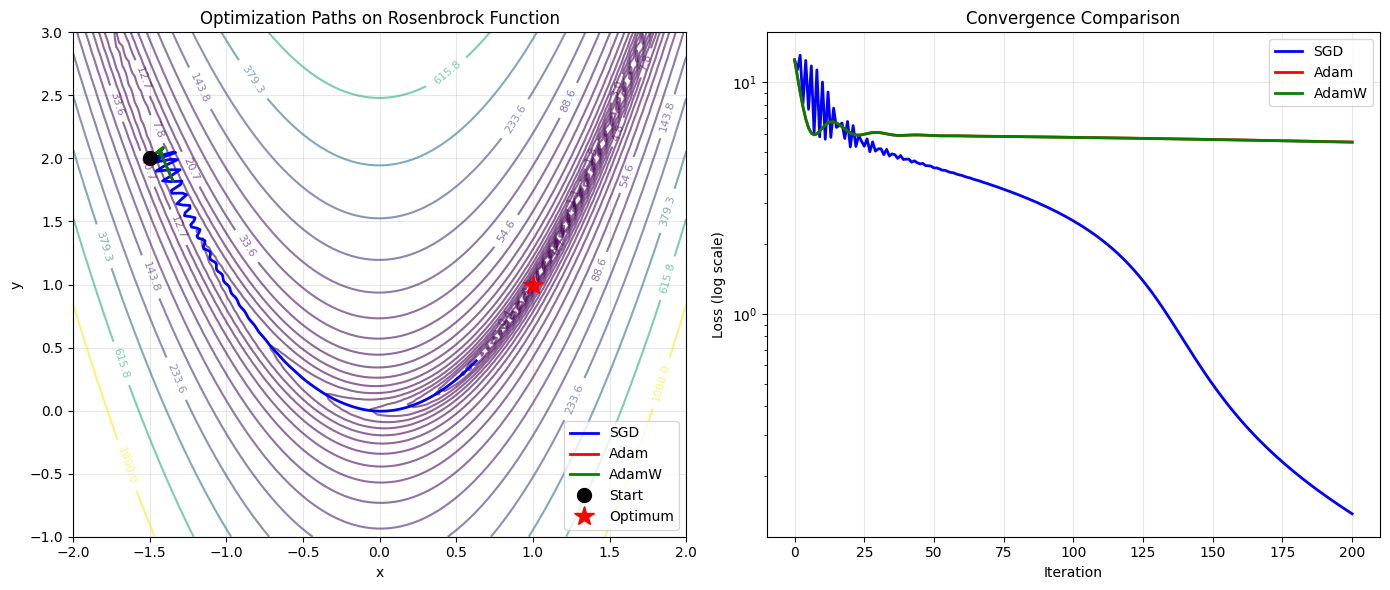

In [11]:
# Visualize optimization paths
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Create contour plot
x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x, y)
Z = rosenbrock(X, Y)

# Plot optimization paths
ax = axes[0]
contour = ax.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='viridis', alpha=0.6)
ax.clabel(contour, inline=True, fontsize=8)

# Plot paths
ax.plot(path_sgd[:, 0], path_sgd[:, 1], 'b-', label='SGD', linewidth=2)
ax.plot(path_adam[:, 0], path_adam[:, 1], 'r-', label='Adam', linewidth=2)
ax.plot(path_adamw[:, 0], path_adamw[:, 1], 'g-', label='AdamW', linewidth=2)

# Mark start and end points
ax.plot(path_sgd[0, 0], path_sgd[0, 1], 'ko', markersize=10, label='Start')
ax.plot(1, 1, 'r*', markersize=15, label='Optimum')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Optimization Paths on Rosenbrock Function')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot convergence curves
ax = axes[1]
ax.semilogy(losses_sgd, 'b-', label='SGD', linewidth=2)
ax.semilogy(losses_adam, 'r-', label='Adam', linewidth=2)
ax.semilogy(losses_adamw, 'g-', label='AdamW', linewidth=2)

ax.set_xlabel('Iteration')
ax.set_ylabel('Loss (log scale)')
ax.set_title('Convergence Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Hyperparameter Sensitivity Analysis

Let's analyze how sensitive different optimizers are to learning rate changes.

In [12]:
def test_learning_rates(optimizer_class, learning_rates, optimizer_kwargs={}):
    """Test optimizer with different learning rates."""
    final_losses = []
    convergence_speeds = []

    for lr in learning_rates:
        # Create model
        model = FeedForwardNet()

        # Create optimizer with specific learning rate
        optimizer = optimizer_class(lr=lr, **optimizer_kwargs)

        # Train model
        history = train_model(model, optimizer, n_epochs=30, batch_size=64, verbose=False)

        # Record metrics
        final_losses.append(history['val_loss'][-1])

        # Calculate convergence speed (epochs to reach 90% of final performance)
        target_loss = history['val_loss'][0] * 0.1 + history['val_loss'][-1] * 0.9
        for epoch, loss in enumerate(history['val_loss']):
            if loss <= target_loss:
                convergence_speeds.append(epoch)
                break
        else:
            convergence_speeds.append(30)  # Max epochs if not converged

    return final_losses, convergence_speeds


# Test learning rates
learning_rates = np.logspace(-4, -1, 10)

print("Testing SGD with different learning rates...")
sgd_losses, sgd_speeds = test_learning_rates(
    braintools.optim.SGD, learning_rates, {'momentum': 0.9}
)

print("Testing Adam with different learning rates...")
adam_losses, adam_speeds = test_learning_rates(
    braintools.optim.Adam, learning_rates
)

print("Testing AdamW with different learning rates...")
adamw_losses, adamw_speeds = test_learning_rates(
    braintools.optim.AdamW, learning_rates, {'weight_decay': 0.01}
)

Testing SGD with different learning rates...
Testing Adam with different learning rates...
Testing AdamW with different learning rates...


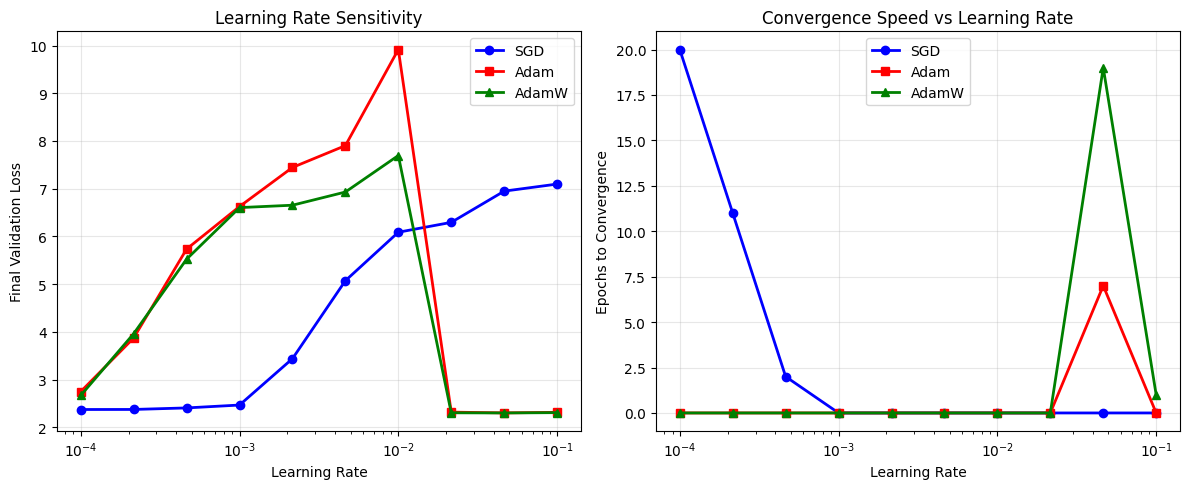

In [13]:
# Plot hyperparameter sensitivity
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Final loss vs learning rate
ax = axes[0]
ax.semilogx(learning_rates, sgd_losses, 'b-o', label='SGD', linewidth=2)
ax.semilogx(learning_rates, adam_losses, 'r-s', label='Adam', linewidth=2)
ax.semilogx(learning_rates, adamw_losses, 'g-^', label='AdamW', linewidth=2)

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Final Validation Loss')
ax.set_title('Learning Rate Sensitivity')
ax.legend()
ax.grid(True, alpha=0.3)

# Convergence speed vs learning rate
ax = axes[1]
ax.semilogx(learning_rates, sgd_speeds, 'b-o', label='SGD', linewidth=2)
ax.semilogx(learning_rates, adam_speeds, 'r-s', label='Adam', linewidth=2)
ax.semilogx(learning_rates, adamw_speeds, 'g-^', label='AdamW', linewidth=2)

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Epochs to Convergence')
ax.set_title('Convergence Speed vs Learning Rate')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary and Key Takeaways

In this tutorial, we've explored the basic optimizers available in braintools:

1. **SGD with Momentum**
   - Simple and reliable
   - Requires careful learning rate tuning
   - Good for convex problems
   - Momentum helps escape local minima

2. **Adam**
   - Adaptive learning rates per parameter
   - Fast convergence
   - Less sensitive to learning rate choice
   - Good default choice for many problems

3. **AdamW**
   - Decoupled weight decay regularization
   - Better generalization than Adam
   - Particularly effective for transformer models
   - Helps prevent overfitting


## Exercises

1. **Learning Rate Scheduling**: Implement a training loop that uses different learning rate schedules (step decay, cosine annealing) and compare their effects.

2. **Custom Loss Function**: Create a custom loss function with L1/L2 regularization and observe how it affects different optimizers.

3. **Batch Size Effects**: Investigate how batch size affects the performance of different optimizers.

4. **Gradient Clipping**: Add gradient clipping to the training loop and analyze its impact on training stability.

5. **Optimizer Combinations**: Try using different optimizers for different parts of the network (e.g., different learning rates for different layers).